In [1]:
cd codes

C:\Users\hwu40\Codes\PWHF\codes


In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import os
from datetime import datetime

from flow_and_mlp import NormalizingFlow, MLP_shift
from solver import fixed_point_optim_solver#Implicit_Euler
from hamiltonian import Hamiltonian_System, quadratic_init#, interaction_potential, quad_potential
from set_train_params import set_params

from evaluation import HO_sol, model_evaluation, eval_traj_error, plot_projection
from record_init import create_eval_rec, create_param_rec, variable_init, HS_init, plot_rec
#from main_alg import HF_main

from others import sample_z, copy_net, tensor_to_numpy

#torch.set_default_dtype(torch.float64)

In [3]:
torch.manual_seed(42)

#params = set_params(potential_type='Coulomb', dim=2)
#params = set_params(potential_type='interaction', dim=2)
params = set_params(potential_type='quadratic', dim=2)
#params = set_params(potential_type='cos', dim=2)

#params['hactivations'] = ['Softplus()', 'Softplus()']#
params['hactivations'] = ['Tanh()', 'Tanh()']#, 'Tanh()']#, 'Tanh()']
params['hlayers'] = [50, 50]#, 100]\
params['init_b'] = None

# params['qw'] = 0.1
# params['iw'] =1.
# params['potential_interact'] = 0.5
params['potential_coef'] = torch.eye(params['dim']).to(params['device'])
params['potential_coef'][1, 1] = 2/3
params['potential_coef'][1, 1] = 2/3
#params['potential_coef'][1, 1] = 1.5
params['potential_coef2'] = - 1.
# params['potential_coef'] = 0.1
params['phiweight'][1, 1] = 0.

params['save'] = True
params['n_savefig'] = 500
now = datetime.now()
    
print('device:', params['device'])

device: cuda:0


In [4]:
if params['save']:
    current_time = now.strftime("%Y-%m-%d %H.%M.%S")
    print("Current Time =", current_time)

    #folder =  os.getcwd() + '/Harmonic Oscillator results/Hamiltonian Flow (DIM={}) '.format(params['dim']) + params['potential_type'] + ' (' + current_time + ')'
    folder =  r'C:\Users\hwu40\Codes\PWHF' + '/Harmonic Oscillator results/Hamiltonian Flow (DIM={}) '.format(params['dim']) + params['potential_type'] + ' (' + current_time + ')'
    
    save_path =  folder#os.getcwd() + '/Hamiltonian Flow DIM = {}'.format(params['dim']) + params['potential_type'] + ' (' + current_time + ')'
    os.makedirs(folder)

Current Time = 2022-12-13 15.34.24


In [5]:
print(save_path)
print(os.getcwd())

C:\Users\hwu40\Codes\PWHF/Harmonic Oscillator results/Hamiltonian Flow (DIM=2) quadratic (2022-12-13 15.34.24)
C:\Users\hwu40\Codes\PWHF\codes


In [6]:
dt = 0.002
niter = 20000 + 1
T = niter * dt

ho_sol, H_system = HS_init(params)

test_points, traj_rec, KE_rec, PE_rec, H_rec, traj_err_rec = create_eval_rec(params, dt, niter)

flow, flow_auxil, pstate, eta = variable_init(params, H_system.phi_zero, niter, dt, T)

nparams = len(nn.utils.parameters_to_vector(flow.parameters()))
theta_rec, p_rec, errrel_rec = create_param_rec(niter, params['nrec'], nparams)

theta_rec.append(tensor_to_numpy(nn.utils.parameters_to_vector(flow.parameters()))); p_rec.append(pstate.reshape(-1))

xtest1 = sample_z(10000, params['dim'], torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
xtest1[0] = torch.Tensor([.75, .75]).to(params['device']); xtest1[1] = torch.Tensor([.75, 1.]).to(params['device'])
xtest1[2] = torch.Tensor([1., .75]).to(params['device'])
length = 1.
angle = np.pi * np.arange(0., 2., 0.1)

z = np.zeros([len(angle), 2])
z[:, 0] = length * np.cos(angle)
z[:, 1] = length * np.sin(angle)
#print(z)
test_points = torch.Tensor(z).to(params['device'])
xtest1 = torch.Tensor(z).to(params['device'])

xtest2, _ = flow(test_points)

xtest = torch.cat((xtest2, xtest1), 0)
xtest = torch.Tensor(tensor_to_numpy(xtest)).to(params['device'])
v_init = H_system.numerical_init(xtest)

xtest_rec = list(); vtest_rec = list()

len_test = xtest2.shape[0]
traj_rec.append(tensor_to_numpy(xtest2)); xtest_rec.append(tensor_to_numpy(xtest2))
vtest_rec.append(tensor_to_numpy(v_init[0:len_test, :]))

In [7]:
print(params['restart'])

2


In [8]:
print(xtest1)

tensor([[ 1.0000e+00,  0.0000e+00],
        [ 9.5106e-01,  3.0902e-01],
        [ 8.0902e-01,  5.8779e-01],
        [ 5.8779e-01,  8.0902e-01],
        [ 3.0902e-01,  9.5106e-01],
        [ 6.1232e-17,  1.0000e+00],
        [-3.0902e-01,  9.5106e-01],
        [-5.8779e-01,  8.0902e-01],
        [-8.0902e-01,  5.8779e-01],
        [-9.5106e-01,  3.0902e-01],
        [-1.0000e+00,  1.2246e-16],
        [-9.5106e-01, -3.0902e-01],
        [-8.0902e-01, -5.8779e-01],
        [-5.8779e-01, -8.0902e-01],
        [-3.0902e-01, -9.5106e-01],
        [-1.8370e-16, -1.0000e+00],
        [ 3.0902e-01, -9.5106e-01],
        [ 5.8779e-01, -8.0902e-01],
        [ 8.0902e-01, -5.8779e-01],
        [ 9.5106e-01, -3.0902e-01]], device='cuda:0')


In [9]:
# length = 1.
# angle = np.pi * np.arange(0., 2., 0.1)

# z = np.zeros([len(angle), 2])
# z[:, 0] = length * np.cos(angle)
# z[:, 1] = length * np.sin(angle)
# print(z)
# xtest1 = torch.Tensor(z).to(params['device'])
# plt.scatter(z[:, 0], z[:, 1])
# plt.show()

In [10]:
def evaluate_vel(z, flow, dtheta):
    vel = np.zeros([z.shape[0], z.shape[1]])
    x, _ = flow(z)
    #print(x)
    for i in range(z.shape[0]):
        #print(i)
        for j in range(z.shape[1]):
            dx = torch.autograd.grad(x[i, j], flow.parameters(), retain_graph=True)
            vec_dx = tensor_to_numpy(nn.utils.parameters_to_vector(dx))
#             print(vec_dx)
#             print(vec_dx.shape, dtheta.shape)
            vel[i, j] = np.sum(np.multiply(vec_dx, dtheta))
#             print(vec_dx.shape, dtheta.shape)
    return tensor_to_numpy(x), vel

In [11]:
# print(xtest1, flow)
# dtheta = tensor_to_numpy(nn.utils.parameters_to_vector(flow.parameters()))
# print(dtheta)
# velocity = evaluate_vel(xtest1, flow, dtheta)
# print(velocity)

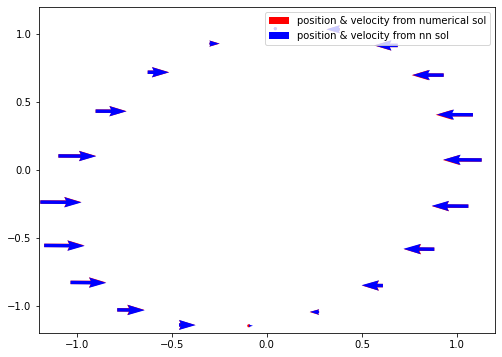

number of iteration: 0
tensor([ 0.1024, -0.1831,  0.2928,  ...,  0.1397,  0.0289, -0.1318],
       device='cuda:0', grad_fn=<CatBackward0>)
[[0. 0.]]
proj of sigma: [0.99999994]


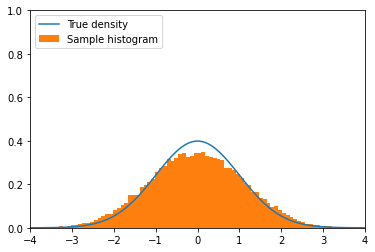

[[0. 0.]]
proj of sigma: [1.]


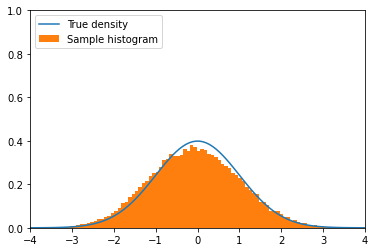

delta 0 in 0 step: 0.001993433
delta 0 in 1 step: 0.0022498255
delta 0 in 2 step: 0.002330112
delta 0 in 3 step: 0.002378567
delta 0 in 4 step: 0.0021040002
delta 0 in 5 step: 0.0022501366
delta 0 in 6 step: 0.0013912391
delta 0 in 7 step: 0.0019405225
delta 0 in 8 step: 0.0021951634
delta 0 in 9 step: 0.0011059685
delta 0 in 10 step: 0.0019214752
delta 0 in 11 step: 0.0010726358
delta 0 in 12 step: 0.001747369
delta 0 in 13 step: 0.0015255994
delta 0 in 14 step: 0.0019896068
delta 0 in 15 step: 0.001976935
delta 0 in 16 step: 0.0020235116
delta 0 in 17 step: 0.002225672
delta 0 in 18 step: 0.002056996
delta 0 in 19 step: 0.0014651075
delta 0 in 20 step: 0.0021338013
delta 0 in 21 step: 0.0020030648
delta 0 in 22 step: 0.002214357
delta 0 in 23 step: 0.0021388074
delta 0 in 24 step: 0.0022314514
delta 0 in 25 step: 0.0022499855
delta 0 in 26 step: 0.0022164173
delta 0 in 27 step: 0.0012736617
delta 0 in 28 step: 0.002355993
delta 0 in 29 step: 0.0010847058
delta 0 in 30 step: 0.0024503

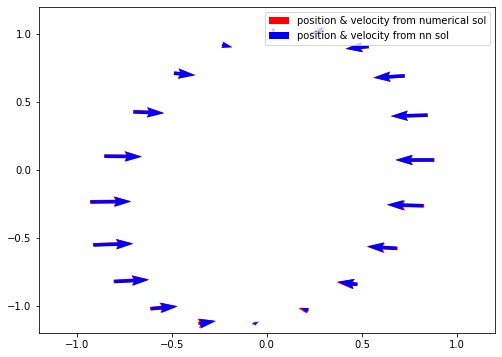

number of iteration: 100
tensor([ 0.1145, -0.1830,  0.3282,  ...,  0.1412,  0.0260, -0.1295],
       device='cuda:0', grad_fn=<CatBackward0>)
delta 0 in 100 step: 0.0017818653
delta 0 in 101 step: 0.0017796807
delta 0 in 102 step: 0.0017188798
delta 0 in 103 step: 0.0014189996
delta 0 in 104 step: 0.0016818485
delta 0 in 105 step: 0.0017431818
delta 0 in 106 step: 0.001698244
delta 0 in 107 step: 0.0017363792
delta 0 in 108 step: 0.001631508
delta 0 in 109 step: 0.0016142926
delta 0 in 110 step: 0.0014873977
delta 0 in 111 step: 0.0016643736
delta 0 in 112 step: 0.0016692466
delta 0 in 113 step: 0.0016601436
delta 0 in 114 step: 0.0016515384
delta 0 in 115 step: 0.0015210583
delta 0 in 116 step: 0.0017510768
delta 0 in 117 step: 0.0016745747
delta 0 in 118 step: 0.0016539128
delta 0 in 119 step: 0.0014680711
delta 0 in 120 step: 0.0015970857
delta 0 in 121 step: 0.0015768817
delta 0 in 122 step: 0.0016151911
delta 0 in 123 step: 0.0015656766
delta 0 in 124 step: 0.0015208567
delta 0 in

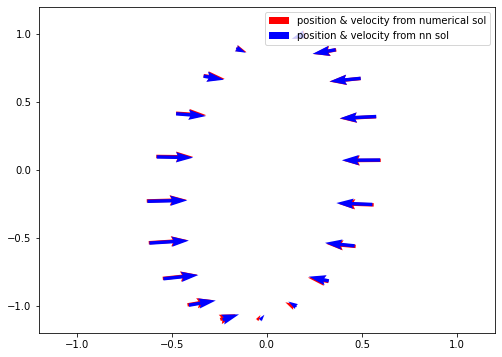

number of iteration: 200
tensor([ 0.1330, -0.1815,  0.3681,  ...,  0.1451,  0.0180, -0.1232],
       device='cuda:0', grad_fn=<CatBackward0>)
delta 0 in 200 step: 0.0016143572
delta 0 in 201 step: 0.001766608
delta 0 in 202 step: 0.0015882987
delta 0 in 203 step: 0.0016220262
delta 0 in 204 step: 0.0017187987
delta 0 in 205 step: 0.0016734893
delta 0 in 206 step: 0.0016783924
delta 0 in 207 step: 0.0017115491
delta 0 in 208 step: 0.001694259
delta 0 in 209 step: 0.0016310798
delta 0 in 210 step: 0.001702577
delta 0 in 211 step: 0.0017149748
delta 0 in 212 step: 0.0016886259
delta 0 in 213 step: 0.0016581323
delta 0 in 214 step: 0.0017517548
delta 0 in 215 step: 0.0018155976
delta 0 in 216 step: 0.001569736
delta 0 in 217 step: 0.0016462742
delta 0 in 218 step: 0.0017521615
delta 0 in 219 step: 0.0017414432
delta 0 in 220 step: 0.0017383746
delta 0 in 221 step: 0.0018036038
delta 0 in 222 step: 0.0018166956
delta 0 in 223 step: 0.0016958524
delta 0 in 224 step: 0.0016888236
delta 0 in 2

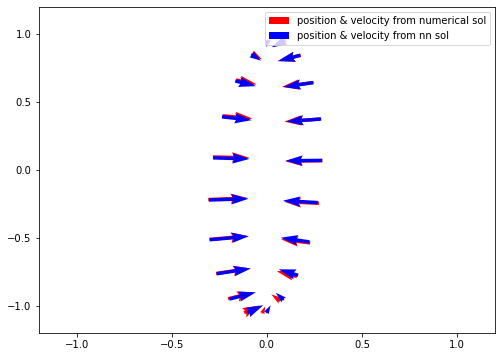

number of iteration: 300
tensor([ 0.1534, -0.1796,  0.4001,  ...,  0.1506,  0.0065, -0.1137],
       device='cuda:0', grad_fn=<CatBackward0>)
delta 0 in 300 step: 0.0017313961
delta 0 in 301 step: 0.0016834197
delta 0 in 302 step: 0.0015644833
delta 0 in 303 step: 0.0017603339
delta 0 in 304 step: 0.0017064329
delta 0 in 305 step: 0.001710278
delta 0 in 306 step: 0.0016654525
delta 0 in 307 step: 0.0016811948
delta 0 in 308 step: 0.0015660612
delta 0 in 309 step: 0.001652777
delta 0 in 310 step: 0.0017740785
delta 0 in 311 step: 0.0016081147
delta 0 in 312 step: 0.0017007439
delta 0 in 313 step: 0.0016789102
delta 0 in 314 step: 0.0017156934
delta 0 in 315 step: 0.0016703648
delta 0 in 316 step: 0.0016774198
delta 0 in 317 step: 0.0016407013
delta 0 in 318 step: 0.0016197715
delta 0 in 319 step: 0.0015607239
delta 0 in 320 step: 0.0017670096
delta 0 in 321 step: 0.0017203
delta 0 in 322 step: 0.0016480599
delta 0 in 323 step: 0.0017008192
delta 0 in 324 step: 0.0017658821
delta 0 in 32

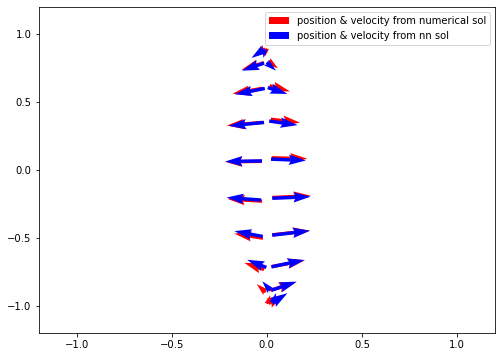

number of iteration: 400
tensor([ 0.1724, -0.1784,  0.4217,  ...,  0.1573, -0.0076, -0.1029],
       device='cuda:0', grad_fn=<CatBackward0>)
delta 0 in 400 step: 0.0017415113
delta 0 in 401 step: 0.0016711159
delta 0 in 402 step: 0.0016395169
delta 0 in 403 step: 0.0015956179
delta 0 in 404 step: 0.001757933
delta 0 in 405 step: 0.0018264807
delta 0 in 406 step: 0.001682367
delta 0 in 407 step: 0.0016572753
delta 0 in 408 step: 0.0016589107
delta 0 in 409 step: 0.0016415064
delta 0 in 410 step: 0.0016512022
delta 0 in 411 step: 0.0017704121
delta 0 in 412 step: 0.0015780012
delta 0 in 413 step: 0.0015673661
delta 0 in 414 step: 0.0016972072
delta 0 in 415 step: 0.0016750324
delta 0 in 416 step: 0.0016894055
delta 0 in 417 step: 0.0016928124
delta 0 in 418 step: 0.0015813367
delta 0 in 419 step: 0.0016415898
delta 0 in 420 step: 0.0015567109
delta 0 in 421 step: 0.0015933624
delta 0 in 422 step: 0.0016407049
delta 0 in 423 step: 0.0016886635
delta 0 in 424 step: 0.0017085283
delta 0 in

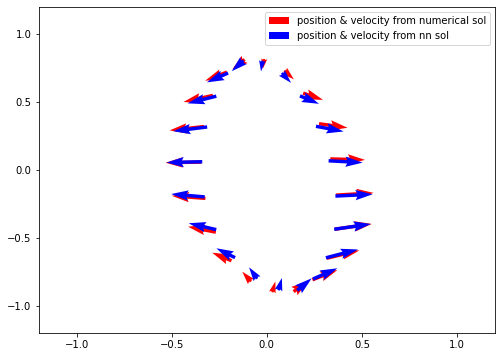

number of iteration: 500
tensor([ 0.1896, -0.1778,  0.4383,  ...,  0.1649, -0.0234, -0.0917],
       device='cuda:0', grad_fn=<CatBackward0>)
[[0. 0.]]
proj of sigma: [-0.3011688]


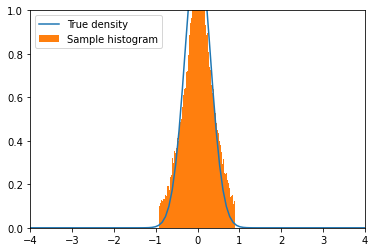

[[0. 0.]]
proj of sigma: [0.78588724]


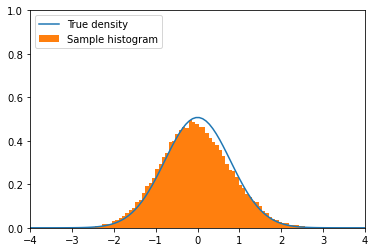

delta 0 in 500 step: 0.0017472444
delta 0 in 501 step: 0.0017781745
delta 0 in 502 step: 0.0016685291
delta 0 in 503 step: 0.0016895027
delta 0 in 504 step: 0.0017169516
delta 0 in 505 step: 0.0017634996
delta 0 in 506 step: 0.001729446
delta 0 in 507 step: 0.0016708457
delta 0 in 508 step: 0.0017099916
delta 0 in 509 step: 0.0018768929
delta 0 in 510 step: 0.0017837556
delta 0 in 511 step: 0.0018001472
delta 0 in 512 step: 0.0017851391
delta 0 in 513 step: 0.001799463
delta 0 in 514 step: 0.0018275811
delta 0 in 515 step: 0.0016926185
delta 0 in 516 step: 0.0017319502
delta 0 in 517 step: 0.001678876
delta 0 in 518 step: 0.0017890157
delta 0 in 519 step: 0.0017798349
delta 0 in 520 step: 0.001793822
delta 0 in 521 step: 0.0017023218
delta 0 in 522 step: 0.0018034667
delta 0 in 523 step: 0.001802432
delta 0 in 524 step: 0.0018194142
delta 0 in 525 step: 0.0016407729
delta 0 in 526 step: 0.0018257289
delta 0 in 527 step: 0.0017858888
delta 0 in 528 step: 0.001685462
delta 0 in 529 step:

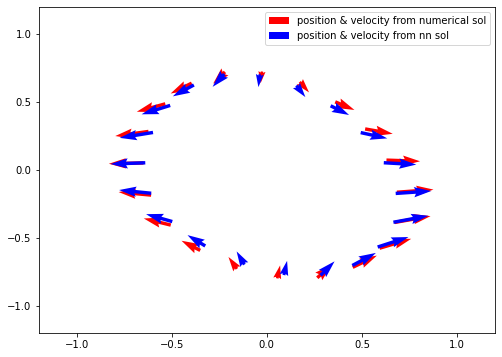

number of iteration: 600
tensor([ 0.2042, -0.1780,  0.4512,  ...,  0.1733, -0.0404, -0.0810],
       device='cuda:0', grad_fn=<CatBackward0>)
delta 0 in 600 step: 0.0017567726
delta 0 in 601 step: 0.0018897078
delta 0 in 602 step: 0.0017102592
delta 0 in 603 step: 0.0018519466
delta 0 in 604 step: 0.0019459209
delta 0 in 605 step: 0.0017941591
delta 0 in 606 step: 0.0019685458
delta 0 in 607 step: 0.0017941546
delta 0 in 608 step: 0.0017488821
delta 0 in 609 step: 0.0019513071
delta 0 in 610 step: 0.0016860258
delta 0 in 611 step: 0.0019423449
delta 0 in 612 step: 0.0018796723
delta 0 in 613 step: 0.0018149144
delta 0 in 614 step: 0.0018312419
delta 0 in 615 step: 0.0017704247
delta 0 in 616 step: 0.0017791651
delta 0 in 617 step: 0.0017401268
delta 0 in 618 step: 0.0017183174
delta 0 in 619 step: 0.00184989
delta 0 in 620 step: 0.0017832683
delta 0 in 621 step: 0.0017800104
delta 0 in 622 step: 0.0018734107
delta 0 in 623 step: 0.0017537079
delta 0 in 624 step: 0.0018727744
delta 0 in

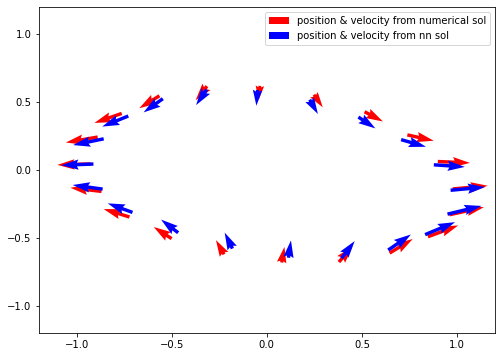

number of iteration: 700
tensor([ 0.2167, -0.1790,  0.4610,  ...,  0.1834, -0.0585, -0.0707],
       device='cuda:0', grad_fn=<CatBackward0>)
delta 0 in 700 step: 0.0020182498
delta 0 in 701 step: 0.0020013321
delta 0 in 702 step: 0.0018437618
delta 0 in 703 step: 0.0019138359
delta 0 in 704 step: 0.001999322
delta 0 in 705 step: 0.0019386279
delta 0 in 706 step: 0.0021035648
delta 0 in 707 step: 0.0018320321
delta 0 in 708 step: 0.0019810137
delta 0 in 709 step: 0.0019682166
delta 0 in 710 step: 0.001905525
delta 0 in 711 step: 0.0019945193
delta 0 in 712 step: 0.001970035
delta 0 in 713 step: 0.0019772165
delta 0 in 714 step: 0.0020577284
delta 0 in 715 step: 0.0020370441
delta 0 in 716 step: 0.002011863
delta 0 in 717 step: 0.0020877765
delta 0 in 718 step: 0.0020485462
delta 0 in 719 step: 0.0019445628
delta 0 in 720 step: 0.0020913784
delta 0 in 721 step: 0.0020605412
delta 0 in 722 step: 0.002108037
delta 0 in 723 step: 0.0019893686
delta 0 in 724 step: 0.002064581
delta 0 in 725

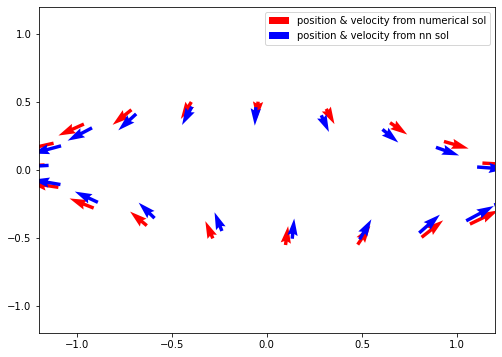

number of iteration: 800
tensor([ 0.2264, -0.1810,  0.4663,  ...,  0.1953, -0.0770, -0.0611],
       device='cuda:0', grad_fn=<CatBackward0>)
delta 0 in 800 step: 0.0022086217
delta 0 in 801 step: 0.0022034978
delta 0 in 802 step: 0.0024125304
delta 0 in 803 step: 0.0022936128
delta 0 in 804 step: 0.002394159
delta 0 in 805 step: 0.00225007
delta 0 in 806 step: 0.002351671
delta 0 in 807 step: 0.002382274
delta 0 in 808 step: 0.0025056936
delta 0 in 809 step: 0.0024737604
delta 0 in 810 step: 0.0024321936
delta 0 in 811 step: 0.0024236368
delta 0 in 812 step: 0.0025628842
delta 0 in 813 step: 0.0024152969
delta 0 in 814 step: 0.0023683365
delta 0 in 815 step: 0.0025048384
delta 0 in 816 step: 0.0024856175
delta 0 in 817 step: 0.002496363
delta 0 in 818 step: 0.0024429879
delta 0 in 819 step: 0.0024472382
delta 0 in 820 step: 0.0025698366
delta 0 in 821 step: 0.002527057
delta 0 in 822 step: 0.0024946583
delta 0 in 823 step: 0.002564541
delta 0 in 824 step: 0.0024892653
delta 0 in 825 s

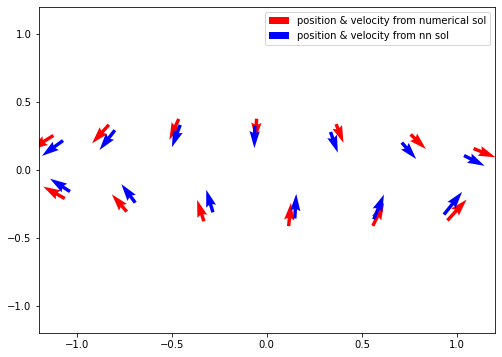

number of iteration: 900
tensor([ 0.2339, -0.1841,  0.4686,  ...,  0.2094, -0.0960, -0.0519],
       device='cuda:0', grad_fn=<CatBackward0>)
delta 0 in 900 step: 0.0029346172
delta 0 in 901 step: 0.002710533
delta 0 in 902 step: 0.0027750984
delta 0 in 903 step: 0.0029775468
delta 0 in 904 step: 0.00306109
delta 0 in 905 step: 0.0031657184
delta 0 in 906 step: 0.002895689
delta 0 in 907 step: 0.0030496942
delta 0 in 908 step: 0.003107771
delta 0 in 909 step: 0.003074708
delta 0 in 910 step: 0.0031026981
delta 0 in 911 step: 0.0031211756
delta 0 in 912 step: 0.0029889073
delta 0 in 913 step: 0.002979482
delta 0 in 914 step: 0.002834651
delta 0 in 915 step: 0.0030959053
delta 0 in 916 step: 0.002979694
delta 0 in 917 step: 0.0030730497
delta 0 in 918 step: 0.0027412525
delta 0 in 919 step: 0.0029291492
delta 0 in 920 step: 0.0028202424
delta 0 in 921 step: 0.002885031
delta 0 in 922 step: 0.0031182456
delta 0 in 923 step: 0.0030970874
delta 0 in 924 step: 0.002957242
delta 0 in 925 step

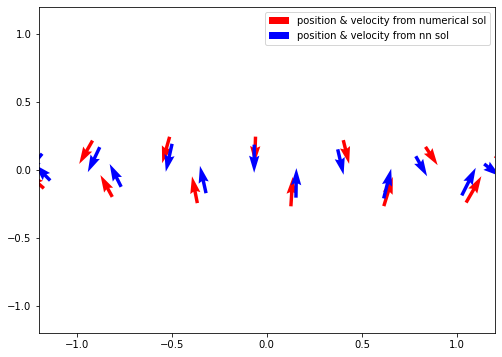

number of iteration: 1000
tensor([ 0.2392, -0.1883,  0.4678,  ...,  0.2265, -0.1158, -0.0427],
       device='cuda:0', grad_fn=<CatBackward0>)
[[0. 0.]]
proj of sigma: [-1.32544422]


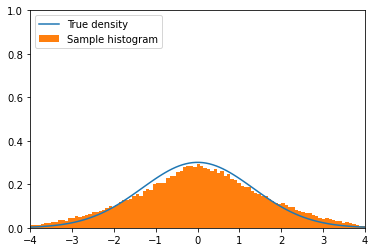

[[0. 0.]]
proj of sigma: [0.23523754]


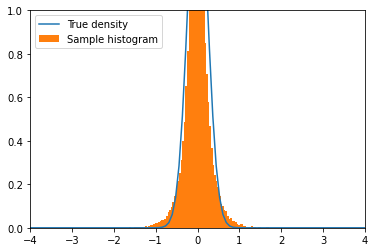

delta 0 in 1000 step: 0.0039036104
delta 0 in 1001 step: 0.0039054826
delta 0 in 1002 step: 0.0036864397
delta 0 in 1003 step: 0.0043523847
delta 0 in 1004 step: 0.0040743463
delta 0 in 1005 step: 0.0042049917
delta 0 in 1006 step: 0.0039010479
delta 0 in 1007 step: 0.00415765
delta 0 in 1008 step: 0.0040988103
delta 0 in 1009 step: 0.0040597683
delta 0 in 1010 step: 0.004254968
delta 0 in 1011 step: 0.004157042
delta 0 in 1012 step: 0.004361288
delta 0 in 1013 step: 0.004153015
delta 0 in 1014 step: 0.0040277434
delta 0 in 1015 step: 0.0040598223
delta 0 in 1016 step: 0.004156171
delta 0 in 1017 step: 0.0044959243
delta 0 in 1018 step: 0.00430614
delta 0 in 1019 step: 0.0041479985
delta 0 in 1020 step: 0.0042941696
delta 0 in 1021 step: 0.004362385
delta 0 in 1022 step: 0.004281753
delta 0 in 1023 step: 0.004041213
delta 0 in 1024 step: 0.004546141
delta 0 in 1025 step: 0.0043087103
delta 0 in 1026 step: 0.0044775405
delta 0 in 1027 step: 0.0044594943
delta 0 in 1028 step: 0.004469464

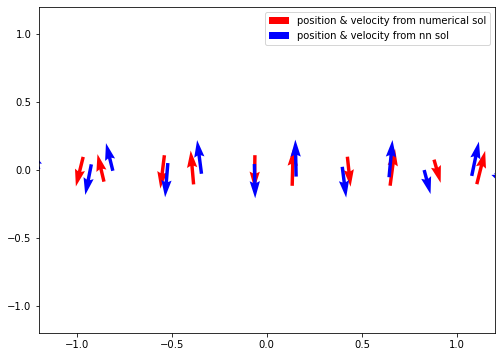

number of iteration: 1100
tensor([ 0.2426, -0.1933,  0.4647,  ...,  0.2460, -0.1357, -0.0342],
       device='cuda:0', grad_fn=<CatBackward0>)
delta 0 in 1100 step: 0.0058397395
delta 0 in 1101 step: 0.0060536265
delta 0 in 1102 step: 0.005994529
delta 0 in 1103 step: 0.0058973506
delta 0 in 1104 step: 0.0058553587
delta 0 in 1105 step: 0.0062585133
delta 0 in 1106 step: 0.0062857205
delta 0 in 1107 step: 0.0059570894
delta 0 in 1108 step: 0.006358475
delta 0 in 1109 step: 0.006375181
delta 0 in 1110 step: 0.006020358
delta 0 in 1111 step: 0.0057539893
delta 0 in 1112 step: 0.00645888
delta 0 in 1113 step: 0.006330114
delta 0 in 1114 step: 0.0064659575
delta 0 in 1115 step: 0.006623566
delta 0 in 1116 step: 0.006259205
delta 0 in 1117 step: 0.0064562983
delta 0 in 1118 step: 0.0063802456
delta 0 in 1119 step: 0.006534628
delta 0 in 1120 step: 0.0063052825
delta 0 in 1121 step: 0.006569661
delta 0 in 1122 step: 0.0064515346
delta 0 in 1123 step: 0.0066005057
delta 0 in 1124 step: 0.0064

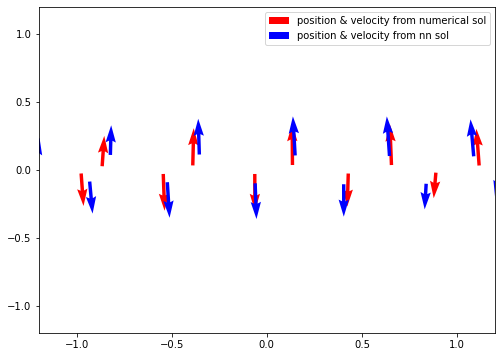

number of iteration: 1200
tensor([ 0.2441, -0.1990,  0.4596,  ...,  0.2668, -0.1549, -0.0265],
       device='cuda:0', grad_fn=<CatBackward0>)
delta 0 in 1200 step: 0.006444132
delta 0 in 1201 step: 0.0065676356
delta 0 in 1202 step: 0.006549315
delta 0 in 1203 step: 0.006374193
delta 0 in 1204 step: 0.006324521
delta 0 in 1205 step: 0.0064889635
delta 0 in 1206 step: 0.0065625035
delta 0 in 1207 step: 0.006545899
delta 0 in 1208 step: 0.0063438294
delta 0 in 1209 step: 0.0063478537
delta 0 in 1210 step: 0.006181266
delta 0 in 1211 step: 0.006174545
delta 0 in 1212 step: 0.0064001177
delta 0 in 1213 step: 0.006221882
delta 0 in 1214 step: 0.0063403267
delta 0 in 1215 step: 0.0061040395
delta 0 in 1216 step: 0.00622839
delta 0 in 1217 step: 0.0061173216
delta 0 in 1218 step: 0.0062885345
delta 0 in 1219 step: 0.006221394
delta 0 in 1220 step: 0.0061588753
delta 0 in 1221 step: 0.005769218
delta 0 in 1222 step: 0.0060617225
delta 0 in 1223 step: 0.005956691
delta 0 in 1224 step: 0.006098

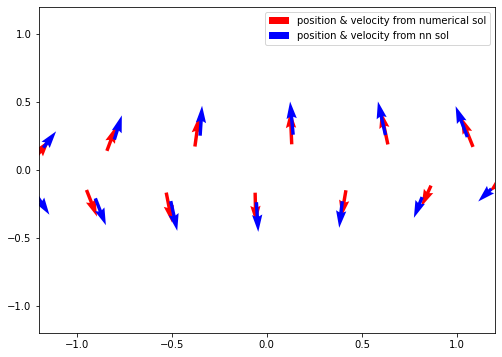

number of iteration: 1300
tensor([ 0.2439, -0.2051,  0.4523,  ...,  0.2880, -0.1732, -0.0198],
       device='cuda:0', grad_fn=<CatBackward0>)
delta 0 in 1300 step: 0.004052127
delta 0 in 1301 step: 0.0042315265
delta 0 in 1302 step: 0.004302878
delta 0 in 1303 step: 0.004196871
delta 0 in 1304 step: 0.004083746
delta 0 in 1305 step: 0.0039653066
delta 0 in 1306 step: 0.0041722246
delta 0 in 1307 step: 0.0038389436
delta 0 in 1308 step: 0.0038079338
delta 0 in 1309 step: 0.0039715264
delta 0 in 1310 step: 0.0040322165
delta 0 in 1311 step: 0.003964528
delta 0 in 1312 step: 0.003976091
delta 0 in 1313 step: 0.0038568357
delta 0 in 1314 step: 0.004048796
delta 0 in 1315 step: 0.003856262
delta 0 in 1316 step: 0.003845745
delta 0 in 1317 step: 0.0037653514
delta 0 in 1318 step: 0.0037256407
delta 0 in 1319 step: 0.0036873887
delta 0 in 1320 step: 0.0038792556
delta 0 in 1321 step: 0.0037173491
delta 0 in 1322 step: 0.0038440232
delta 0 in 1323 step: 0.003964858
delta 0 in 1324 step: 0.003

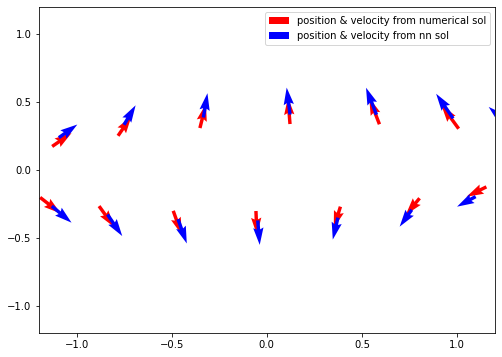

number of iteration: 1400
tensor([ 0.2423, -0.2115,  0.4425,  ...,  0.3091, -0.1904, -0.0139],
       device='cuda:0', grad_fn=<CatBackward0>)
delta 0 in 1400 step: 0.0027930064
delta 0 in 1401 step: 0.002820918
delta 0 in 1402 step: 0.003159067
delta 0 in 1403 step: 0.0027236403
delta 0 in 1404 step: 0.0029375337
delta 0 in 1405 step: 0.0027966206
delta 0 in 1406 step: 0.0028302884
delta 0 in 1407 step: 0.0026564633
delta 0 in 1408 step: 0.0029950363
delta 0 in 1409 step: 0.0026117922
delta 0 in 1410 step: 0.0026694834
delta 0 in 1411 step: 0.0026494986
delta 0 in 1412 step: 0.0029585613
delta 0 in 1413 step: 0.0027539036
delta 0 in 1414 step: 0.0029355914
delta 0 in 1415 step: 0.0028439704
delta 0 in 1416 step: 0.0028004525
delta 0 in 1417 step: 0.0027482773
delta 0 in 1418 step: 0.0028963764
delta 0 in 1419 step: 0.0028229635
delta 0 in 1420 step: 0.0027016138
delta 0 in 1421 step: 0.0027503963
delta 0 in 1422 step: 0.0028525903
delta 0 in 1423 step: 0.0027150074
delta 0 in 1424 ste

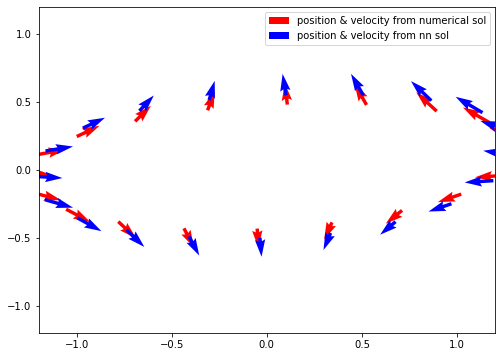

number of iteration: 1500
tensor([ 0.2394, -0.2179,  0.4299,  ...,  0.3284, -0.2059, -0.0088],
       device='cuda:0', grad_fn=<CatBackward0>)
[[0. 0.]]
proj of sigma: [-1.13111246]


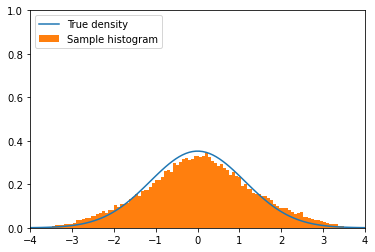

[[0. 0.]]
proj of sigma: [-0.41614681]


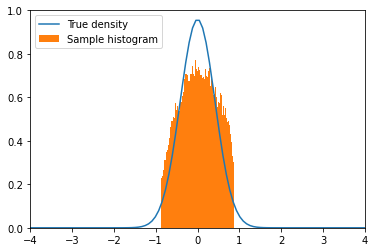

delta 0 in 1500 step: 0.0024797022


In [12]:
from solver import linear_system_solver
delta_eval = True
#stepsize=0.5
lstr=3e-4

t1 = time.time()

xti, vti = xtest, v_init

h_rec, pe_rec, ke_rec = np.zeros(niter), np.zeros(niter), np.zeros(niter)

for i in range(1500+1 ):#niter):
    ### NN solve step:
    if i%params['restart'] == 0:
        eta=None
    relstr = lstr #/ np.sqrt(np.linalg.norm(pstate, 2))
    samples = sample_z(params['nsamples'], params['dim'], params['device'])
    ###d_alpha, d_p, G, s1 = relaxed_Lagrangian_dynamics(H_system, flow, flow_auxil, pstate, samples, lstr)
    xi, pstate, res, err = fixed_point_optim_solver(H_system, flow, flow_auxil, pstate, dt, samples, relstr, 
                   params['px_iters'], params['xi_lr'], params['ls_solver_type'], eta, pe_samplesize=None)
    eta = xi
    alpha = nn.utils.parameters_to_vector(flow.parameters()) + torch.Tensor(dt * xi).to(params['device'])
#     return alpha, pstate, res, err, xi, samples
#     newalpha, pstate, res, errrel, eta, samples = solver.step(H_system, flow, flow_auxil, pstate, 
#                                                               params, relstr, i,eta, params['print_type'], pe_samplesize=params['pe_samplesize'])
    ### Numerical solve step:
    if params['potential_type']=='quadratic':
        mu, sigma = ho_sol.Gauss_param(dt * i)    
#         xti = torch.matmul(xtest2, torch.Tensor(sigma).to(params['device']))
#         vti = None
#     else:
        xti = torch.Tensor(tensor_to_numpy(xti)).to(params['device'])
        xti, vti = H_system.numerical_step(xti, vti, dt)
        #h_rec[i], pe_rec[i], ke_rec[i] = H_system.energy_eval(xti, vti)
    
    if i%100==0:
        posx, velocity = evaluate_vel(test_points, flow, xi)
        npxti = tensor_to_numpy(xti)
        npvti = tensor_to_numpy(vti)

        fig = plt.figure(figsize=(18, 6))
        ax = fig.add_subplot(121)
        ax.set_xlim([-1.2, 1.2])
        ax.set_ylim([-1.2, 1.2])
        ax.quiver(npxti[:len(xtest2), 0],npxti[:len(xtest2), 1],npvti[:len(xtest2), 0],npvti[:len(xtest2), 1], color='red',
                  label='position & velocity from numerical sol')
        ax.quiver(posx[:, 0],posx[:, 1],velocity[:, 0],velocity[:, 1], color='blue', label='position & velocity from nn sol')
        #plt.quiver(xti[:, 0],posx[:, 1],velocity[:, 0],velocity[:, 1])
        plt.legend(loc='upper right')
        plt.show()
#         filename_samples = os.path.join(save_path,  "(" + params['potential_type'] + ") " + "velocity at {}-th step ".format(i))
#         plt.title("velocity in {}-th step ".format(1+i))
#         plt.savefig(filename_samples)
#         plt.close()
        
        print('number of iteration:', i)
        print(nn.utils.parameters_to_vector(flow.parameters()))
        #traj_err = model_evaluation(flow, ho_sol, params, samples, samples, i*dt)


    if i%params['nrec']==0:
        theta_rec.append(tensor_to_numpy(nn.utils.parameters_to_vector(flow.parameters())))
        p_rec.append(pstate.reshape(-1))
        rec_x, _ = flow(test_points)
        np_recx = tensor_to_numpy(rec_x)
        traj_rec.append( np_recx )
        xtest_rec.append(tensor_to_numpy(xti[0:len_test, :]))#; vtest_rec.append(tensor_to_numpy(vti[0:len_test, :]))
        
        if (i%params['n_savefig']==0)&(params['save']):
            if params['potential_type']=='quadratic':
                #save_hist = os.path.join(save_path,  "sample histogram at {}-th step ".format(1+i))
                plot_projection(save_path, flow, params, samples, mu, sigma, i, num=100)
            plot_samples = sample_z(2000, 2, samples.device)
            draw_x, _ = flow(plot_samples)
            draw_x = tensor_to_numpy(draw_x)
            plt.scatter(draw_x[:, 0], draw_x[:, 1])
            filename_samples = os.path.join(save_path,  "(" + params['potential_type'] + ") " + "samples at {}-th step ".format(i))
            plt.title("samples in {}-th step ".format(1+i))
            plt.savefig(filename_samples)
            plt.close()
    if delta_eval:
        xs, log_jac = flow(samples)
        potential_E = H_system.potential_eval(xs, log_jac)
        grad_V = torch.autograd.grad(potential_E, flow.parameters())
        np_grad_V = tensor_to_numpy(nn.utils.parameters_to_vector(grad_V))
        _, _, err = linear_system_solver(flow, flow_auxil, pstate, samples, lstr, solver_type=params['ls_solver_type'])
        print('delta 0 in {} step:'.format(i), err)
        
#     if (i%params['nrec']==0) & (params['dim']<=2):
# #         wsamples = sample_z(5000, params['dim'], params['device'])
# #         wsamples = torch.matmul(wsamples, torch.Tensor(sigma).to(params['device']))

#         wsamples = xti[0:5000, :]
#         hsamples = sample_z(5000, 2, samples.device)
#         nnsamples, _ = flow(hsamples)
#         w2_eval = sinkh(wsamples, nnsamples)
#         #w2_eval = ot.emd2([], [], tensor_to_numpy(torch.cdist(x, y, p=2)))
#         w2_rec.append(tensor_to_numpy(w2_eval))

    #traj_err_rec[i] = eval_traj_error(samples, flow, sol_func)
    hsamples = sample_z(10000, 2, samples.device)
    ke, pe = H_system.Hamiltonian_eval(flow, flow_auxil, torch.Tensor(eta).to(params['device']), hsamples)
    KE_rec[i], PE_rec[i] = tensor_to_numpy(ke), tensor_to_numpy(pe)
    H_rec[i] = KE_rec[i] + PE_rec[i] 

theta_record = np.stack(theta_rec, axis=0)
p_record = np.stack(p_rec, axis=0)
traj_record = np.stack(traj_rec, axis=0)

# if params['dim']<=2:
#     w2_record = np.stack(w2_rec, axis=0)
#     plt.plot(w2_record)
#     filename_w2 = os.path.join(save_path, "(" + params['potential_type'] + ") " +  "sinkhorn divergence")
#     plt.title("sinkhorn divergence ")
#     plt.savefig(filename_w2)
#     plt.show()
#     plt.close()
    
xtest_record = np.stack(xtest_rec, axis=0)
vtest_record = np.stack(vtest_rec, axis=0)

t2 = time.time()
rtime = t2-t1
lines_runtime = ['It takes {0:.2f} seconds to finish the solving procedure.'.format(rtime)]
#with open(record_file, 'a') as f:
#    f.writelines(lines_runtime)

In [13]:
print(nn.utils.parameters_to_vector(flow.parameters()))

tensor([ 0.2166, -0.1790,  0.4609,  ...,  0.1833, -0.0583, -0.0708],
       device='cuda:0', grad_fn=<CatBackward0>)


In [ ]:
length = 1.
angle = np.pi * np.arange(0., 2., 0.1)

z = np.zeros([len(angle), 2])
z[:, 0] = length * np.cos(angle)
z[:, 1] = length * np.sin(angle)
#print(z)
test_points = torch.Tensor(z).to(params['device'])

In [14]:
print(test_points)

tensor([[ 1.0000e+00,  0.0000e+00],
        [ 9.5106e-01,  3.0902e-01],
        [ 8.0902e-01,  5.8779e-01],
        [ 5.8779e-01,  8.0902e-01],
        [ 3.0902e-01,  9.5106e-01],
        [ 6.1232e-17,  1.0000e+00],
        [-3.0902e-01,  9.5106e-01],
        [-5.8779e-01,  8.0902e-01],
        [-8.0902e-01,  5.8779e-01],
        [-9.5106e-01,  3.0902e-01],
        [-1.0000e+00,  1.2246e-16],
        [-9.5106e-01, -3.0902e-01],
        [-8.0902e-01, -5.8779e-01],
        [-5.8779e-01, -8.0902e-01],
        [-3.0902e-01, -9.5106e-01],
        [-1.8370e-16, -1.0000e+00],
        [ 3.0902e-01, -9.5106e-01],
        [ 5.8779e-01, -8.0902e-01],
        [ 8.0902e-01, -5.8779e-01],
        [ 9.5106e-01, -3.0902e-01]], device='cuda:0')


In [15]:
print(xtest1, flow)

print(xi)
posx, velocity = evaluate_vel(test_points, flow, xi)
print(velocity)

tensor([[ 1.0000e+00,  0.0000e+00],
        [ 9.5106e-01,  3.0902e-01],
        [ 8.0902e-01,  5.8779e-01],
        [ 5.8779e-01,  8.0902e-01],
        [ 3.0902e-01,  9.5106e-01],
        [ 6.1232e-17,  1.0000e+00],
        [-3.0902e-01,  9.5106e-01],
        [-5.8779e-01,  8.0902e-01],
        [-8.0902e-01,  5.8779e-01],
        [-9.5106e-01,  3.0902e-01],
        [-1.0000e+00,  1.2246e-16],
        [-9.5106e-01, -3.0902e-01],
        [-8.0902e-01, -5.8779e-01],
        [-5.8779e-01, -8.0902e-01],
        [-3.0902e-01, -9.5106e-01],
        [-1.8370e-16, -1.0000e+00],
        [ 3.0902e-01, -9.5106e-01],
        [ 5.8779e-01, -8.0902e-01],
        [ 8.0902e-01, -5.8779e-01],
        [ 9.5106e-01, -3.0902e-01]], device='cuda:0') MLP_shift(
  (map): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=2, bias=False)
  )
)
[ 0.05518122 

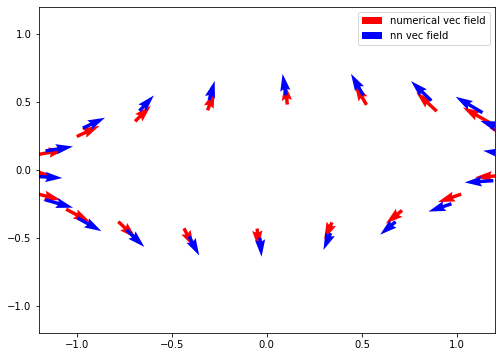

In [14]:
npxti = tensor_to_numpy(xti)
npvti = tensor_to_numpy(vti)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(121)
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.quiver(npxti[:len(xtest2), 0],npxti[:len(xtest2), 1],npvti[:len(xtest2), 0],npvti[:len(xtest2), 1], color='red', label='numerical vec field')
ax.quiver(posx[:, 0],posx[:, 1],velocity[:, 0],velocity[:, 1], color='blue', label='nn vec field')
#plt.quiver(xti[:, 0],posx[:, 1],velocity[:, 0],velocity[:, 1])
plt.legend(loc='upper right')
plt.show()

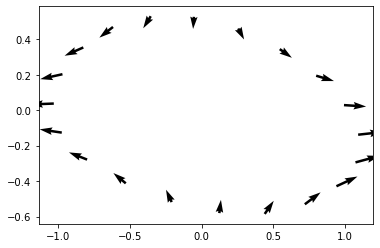

In [16]:
#posx = tensor_to_numpy(xtest1)
plt.quiver(posx[:, 0],posx[:, 1],velocity[:, 0],velocity[:, 1])
#plt.quiver(xti[:, 0],posx[:, 1],velocity[:, 0],velocity[:, 1])
plt.show()

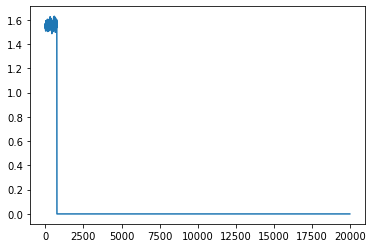

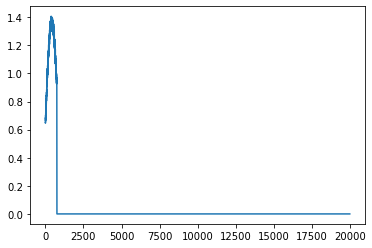

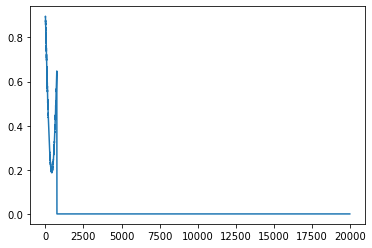

In [14]:
plt.plot(H_rec)
plt.show()
#plt.savefig(os.path.join(save_path, "(" + params['potential_type'] + ") " + "Hamiltonian plot"))
plt.close()

plt.plot(KE_rec)
plt.show()
#plt.savefig(os.path.join(save_path,  "(" + params['potential_type'] + ") " + "Kinetic energy plot"))
plt.close()

plt.plot(PE_rec)
plt.show()  
#plt.savefig(os.path.join(save_path,  "(" + params['potential_type'] + ") " + "Potential energy plot"))
plt.close()
#plt.plot(traj_err_rec)
#plt.show() 

In [15]:
# plt.plot(h_rec)
# plt.show()
# plt.plot(ke_rec)
# plt.show()
# plt.plot(pe_rec)
# plt.show()  

In [16]:
def plot_w(wset, dt, idim):
    nstep = wset.shape[0]
    timeset = np.linspace(0, dt * nstep, num = wset.shape[0])
    for j in range(len(wset[0])):
        point_traj = wset[:, j, idim]
        plt.plot(timeset, point_traj, label='{}-th point'.format(j))
    plt.xlabel('time - axis')
    plt.ylabel('space - axis')
    plt.show()
    return None

(76, 100, 2)
0-th dimension:


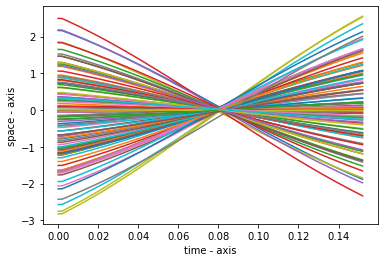

1-th dimension:


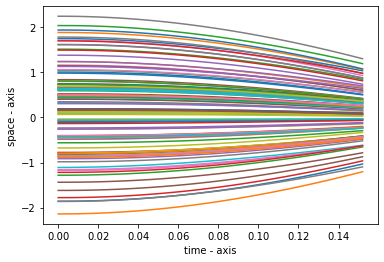

In [17]:
wt = traj_record
print(wt.shape)
for i in range(params['dim']):
    print('{}-th dimension:'.format(i))
    plot_w(wt, dt, i)

(76, 100, 2)
0-th dimension:


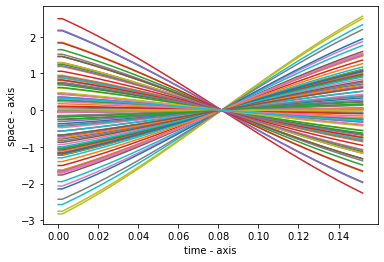

1-th dimension:


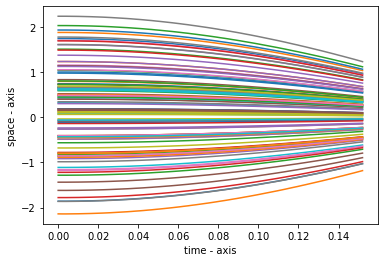

In [18]:
wt2 = xtest_record
print(wt2.shape)
for i in range(params['dim']):
    print('{}-th dimension:'.format(i))
    plot_w(wt2, dt, i)

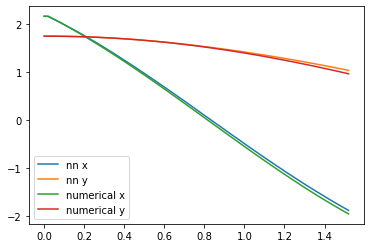

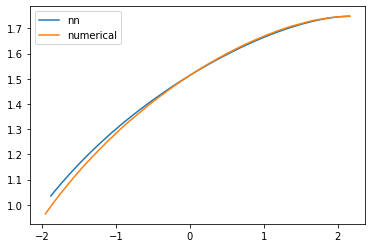

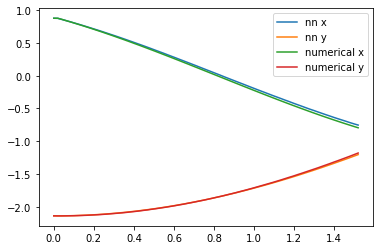

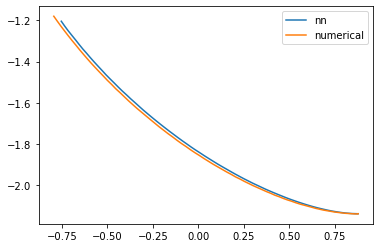

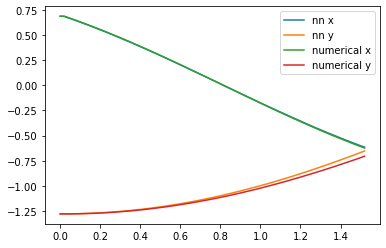

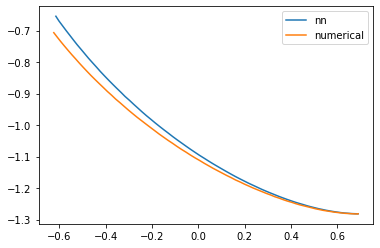

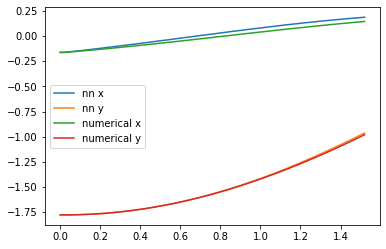

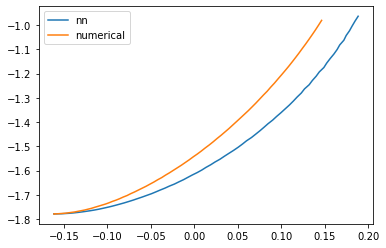

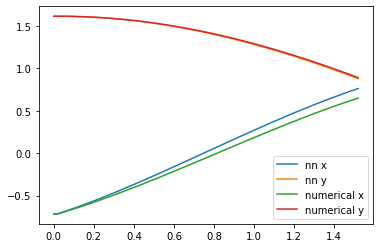

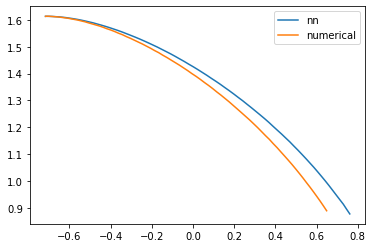

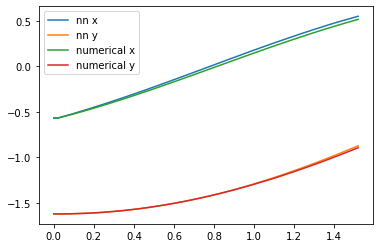

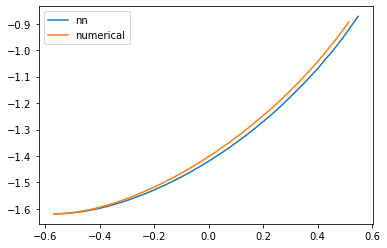

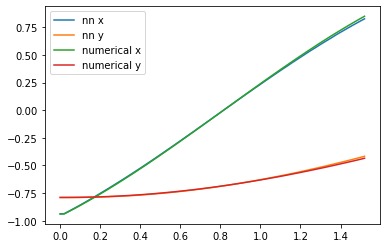

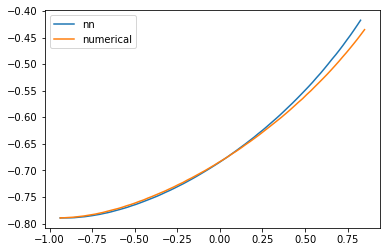

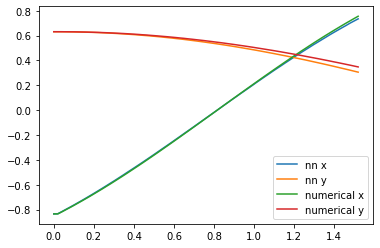

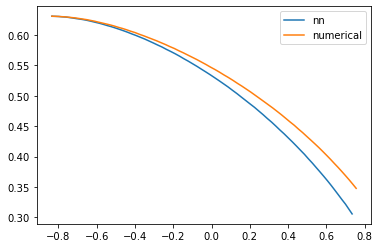

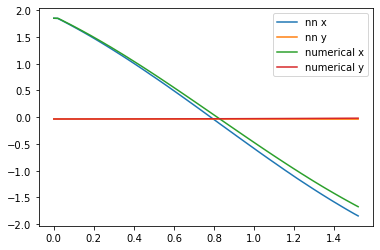

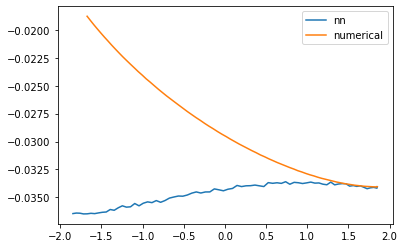

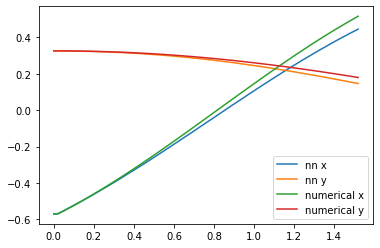

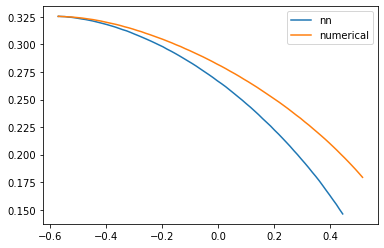

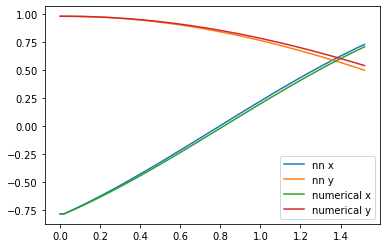

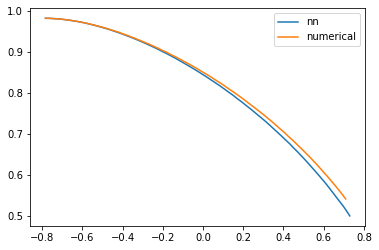

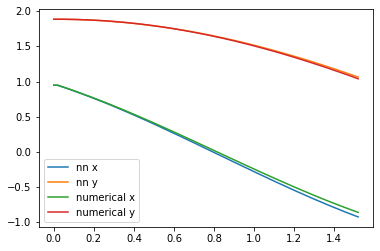

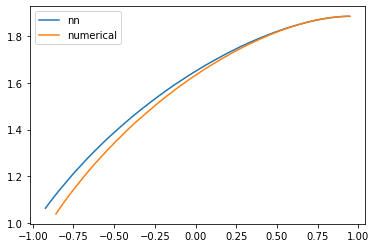

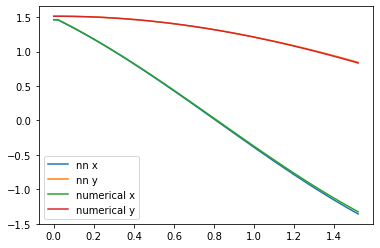

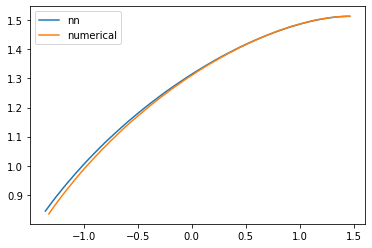

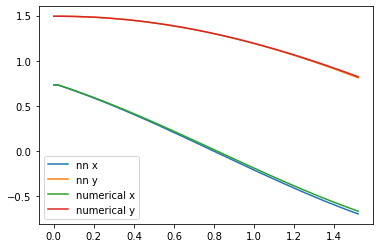

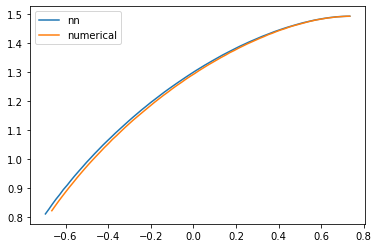

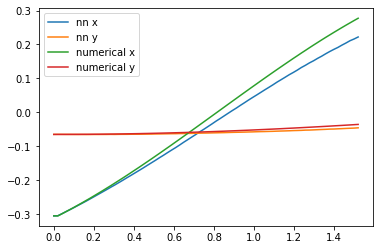

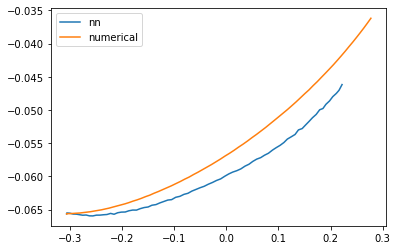

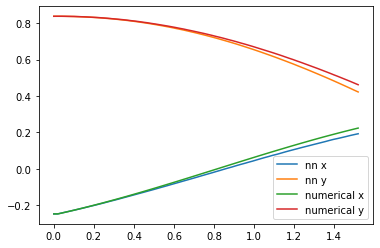

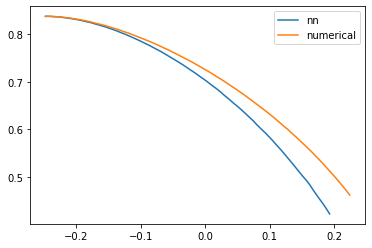

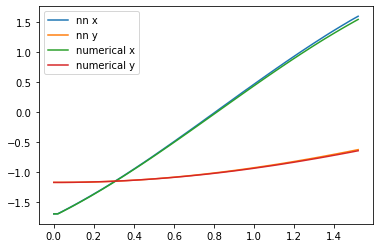

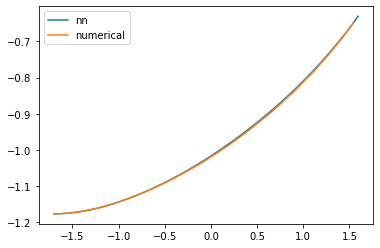

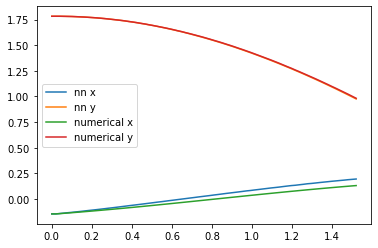

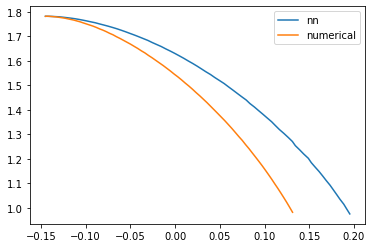

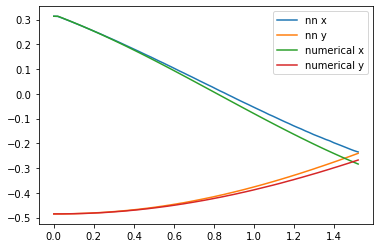

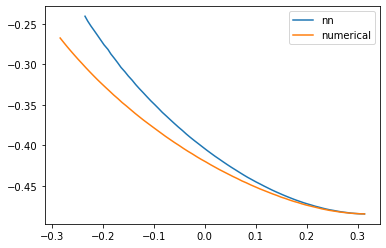

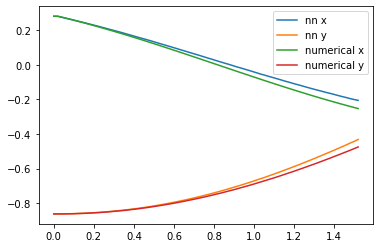

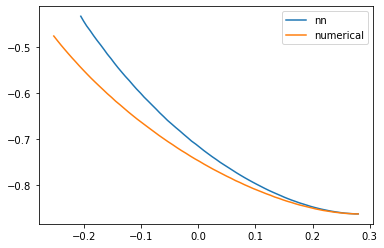

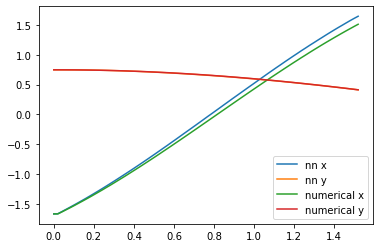

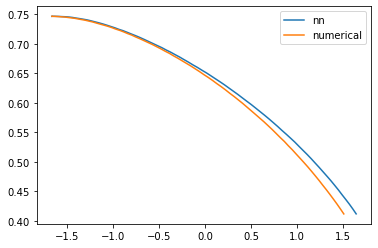

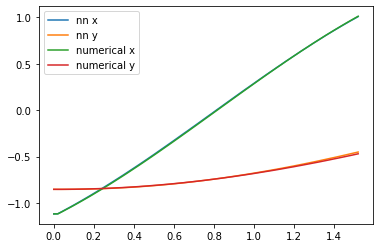

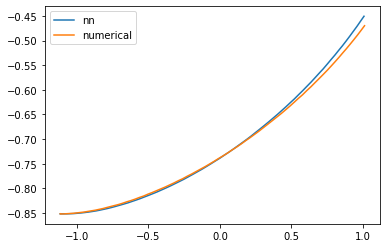

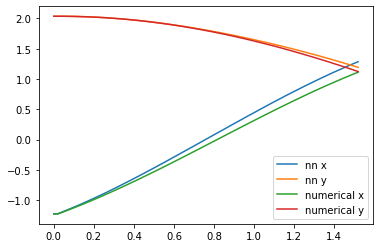

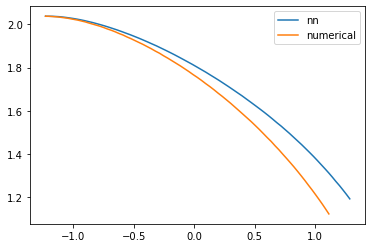

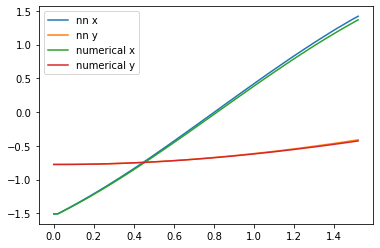

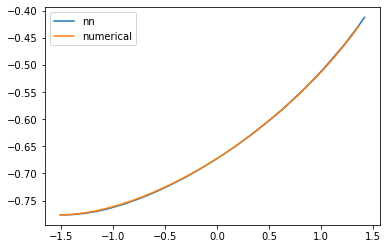

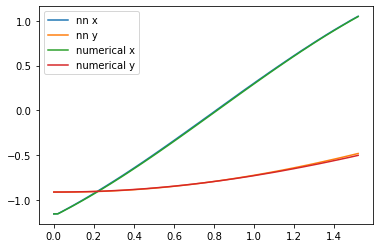

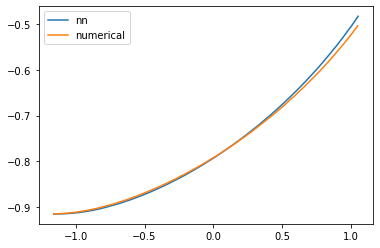

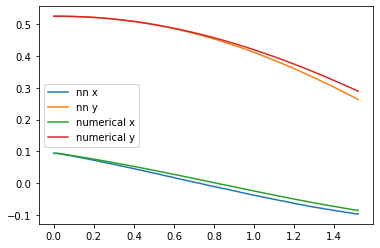

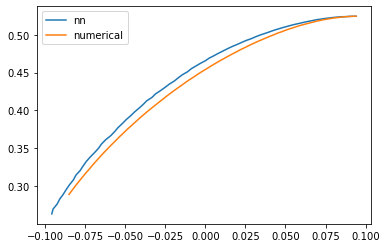

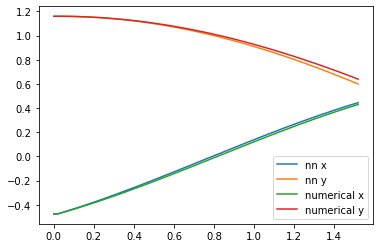

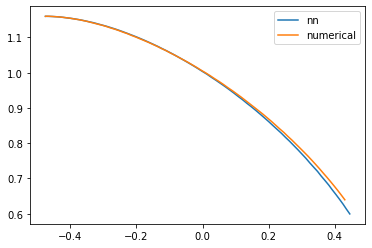

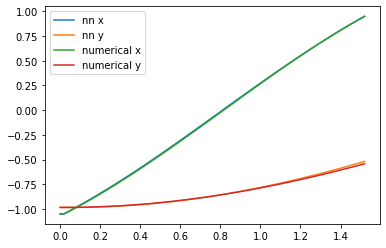

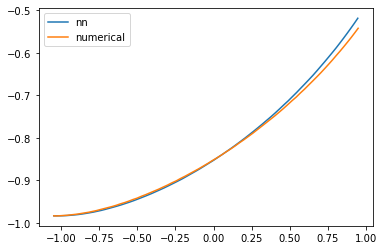

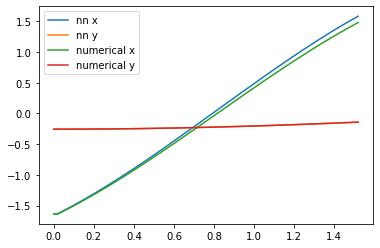

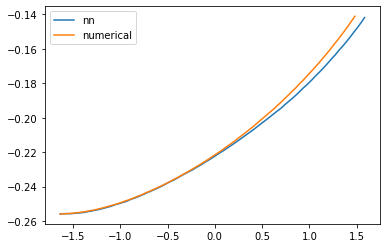

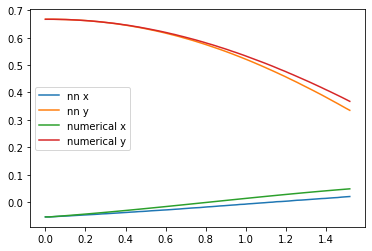

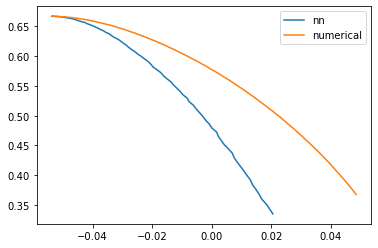

In [19]:
#    j = 24
for j in range(30):
    x1 = wt[:, j, 0]; y1 = wt[:, j, 1]
    x2 = wt2[:, j, 0]; y2 = wt2[:, j, 1]

    timeset = np.linspace(0, params['nrec'] * dt *  wt.shape[0], num = wt.shape[0])

    plt.plot(timeset, x1, label='nn x')
    plt.plot(timeset, y1, label='nn y')
    plt.plot(timeset, x2, label='numerical x')
    plt.plot(timeset, y2, label='numerical y')
    plt.legend()
    #plt.show()
    plt.savefig(os.path.join(save_path, "(" + params['potential_type'] + ") " +  "fisrt sample projection plot"))
    plt.show()
    plt.close()

    plt.plot(x1, y1, label='nn')
    plt.plot(x2, y2, label='numerical')
    plt.legend()
    #plt.show()
    plt.savefig(os.path.join(save_path, "(" + params['potential_type'] + ") " +  "fisrt sample trajectory plot"))
    plt.show()
    plt.close()

In [20]:
p1_traj_folder = save_path + "/p1 traj"
os.makedirs(p1_traj_folder)

In [21]:
# for i in range(len(x1)):
#     fig, ax = plt.subplots(figsize=(8, 6))
#     plt.plot(x1[i], y1[i], label='PWHF solution', marker='o', markerfacecolor='blue')
#     plt.plot(x2[i], y2[i], label='True solution', marker='o', markerfacecolor='red')
#     ax.set_xlim([-2., 2.])
#     ax.set_ylim([-1.5, 1.5])
#     plt.legend()
#     #plt.show()
#     plt.savefig(os.path.join(p1_traj_folder, "HO 2d " +  "fisrt sample trajectory plot {}".format(i)+'.jpeg'))
#     plt.show()
#     plt.close()

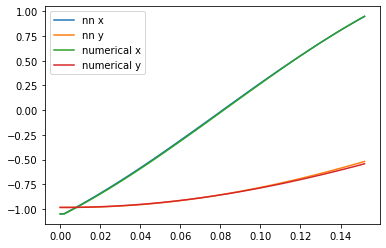

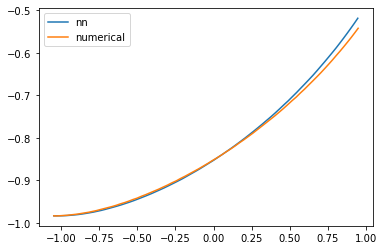

In [22]:
j = 27

x1 = wt[:, j, 0]; y1 = wt[:, j, 1]
x2 = wt2[:, j, 0]; y2 = wt2[:, j, 1]

timeset = np.linspace(0, dt *  wt.shape[0], num = wt.shape[0])

plt.plot(timeset, x1, label='nn x')
plt.plot(timeset, y1, label='nn y')
plt.plot(timeset, x2, label='numerical x')
plt.plot(timeset, y2, label='numerical y')
plt.legend()
#plt.show()
plt.savefig(os.path.join(save_path, "(" + params['potential_type'] + ") " +  "second sample projection plot"))
plt.show()
plt.close()

plt.plot(x1, y1, label='nn')
plt.plot(x2, y2, label='numerical')
plt.legend()
#plt.show()
plt.savefig(os.path.join(save_path, "(" + params['potential_type'] + ") " +  "second sample trajectory plot"))
plt.show()
plt.close()

In [23]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.
